In [391]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm

def numbering_class(x):
    if x =='Very Good':
        return 4
    if x =='Good':
        return 3
    if x =='Bad':
        return 2
    if x =='Very Bad':
        return 1
    
def get_int(x):
    try:
        try: 
            return int(x)
        except:
            return int(x.replace(",",""))
    except:
        return x
    
def data_change(s):
    s_list = s.split()
    s_list = [get_int(s[:-1]) for s in s_list[:4]]
    s_list
    if s_list[-1]=="A":
        s_list[-2] -= 1
        if s_list[-2] == 0:
            s_list[-2]=31
            s_list[-3] -= 1

    s_list = [str(s) for s in s_list[:-1]]
    
    return "/".join(s_list)

def data_change2(s):
    s_list = s.split()[:3]

    if s_list[0] == 'October':
        s_list[0] = str(10)

    if s_list[0] == 'November':
        s_list[0] = str(11)
    order = [2,0,1]
    # s_list[order]
    _list= []
    _list.append(int(s_list[2]))
    _list.append(int(s_list[0]))
    _list.append(int(s_list[1][:-1]))

    _list[-1] -= 1
    if _list[-1] == 0:
        _list[-1]=31
        _list[-2] -= 1
    _list = [str(s) for s in _list]
    return"/".join(_list)

def data_change3(s):
    s_list = s.split()
    s_list = [get_int(s[:-1]) for s in s_list[:4]]

    s_list = [str(s) for s in s_list[:]]
    
    return "/".join(s_list)

In [394]:
target_name = "태형"
df_s = pd.read_csv("no_sleep.csv", encoding="latin1")
df_s = df_s.drop(["end_date"], axis=1)
df_s = df_s[df_s["sleep_time"]>180]
df_s["start_date"] = df_s["start_date"].apply(data_change)
df_s.rename(columns = {'start_date':'date'},inplace=True)

df = pd.read_csv("no_act.csv", encoding="latin1")
df["cal"] = df["cal"].apply(get_int)
df["step"] = df["step"].apply(get_int)
df["stop"] = df["stop"].apply(get_int)
df["burn_cal"] = df["burn_cal"].apply(get_int)
df["date"] = df["date"].apply(data_change3)

df = df.drop(["stair"],axis=1)

In [395]:
ans = pd.read_csv("target.csv")[["생성 일시", target_name]]
ans[target_name] = ans[target_name].apply(numbering_class)

ans['생성 일시'] = ans['생성 일시'].apply(data_change2)

ans = ans.dropna()

ans.columns = ["date","target"]

In [396]:
df_f = pd.merge(df, df_s, on='date', how='inner')

df_ans = pd.merge(df_f, ans, on='date', how='inner')

df_ans["inter"] = 1

df_ans.drop_duplicates(subset="date", keep='first', inplace=True, ignore_index=False)

In [397]:
trn = df_ans.drop(["target","date"],axis=1)[:-5]
trn_a = df_ans["target"][:-5].apply(int) - 1

val = df_ans.drop(["target","date"],axis=1)[-5:]
tst = df_ans["target"][-5:].apply(int) - 1

In [398]:
from xgboost import XGBClassifier
import lightgbm as lgb

In [399]:
# train_ds = lgb.Dataset(trn,label=ans)

In [454]:
model = XGBClassifier(n_estimators=500, learning_rate=0.2, max_depth=4, random_state = 32)

In [455]:
model.fit(trn, trn_a)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=32, reg_alpha=0, ...)

In [456]:
pred = model.predict(val)

In [457]:
test = df_ans[["date","target"]][-5:]

test["pred"] = pred+1

test["target"] = test["target"].apply(int)

In [458]:
test.style.hide_index()

date,target,pred
2022/10/25,2,3
2022/10/26,2,3
2022/10/27,2,1
2022/10/29,4,4
2022/10/30,3,2


In [460]:
val

,cal,step,dist,stop,light_act,heavy_act,hard_act,burn_cal,sleep_time,awake_time,awake_count,total_sleep,rem,light_sleep,deep_sleep,inter
23,2762,9267,6.64,762,191,33,43,1260,360,57,29,417,68.0,236.0,56.0,1
24,2884,11255,8.09,730,224,29,40,1420,299,75,12,374,82.0,156.0,61.0,1
25,2561,8327,5.98,883,133,10,40,948,267,59,12,326,57.0,148.0,62.0,1
26,2086,2987,2.15,693,107,0,0,466,358,78,23,436,72.0,225.0,61.0,1
27,2506,7526,5.40,813,135,28,28,935,342,61,29,403,67.0,248.0,27.0,1


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

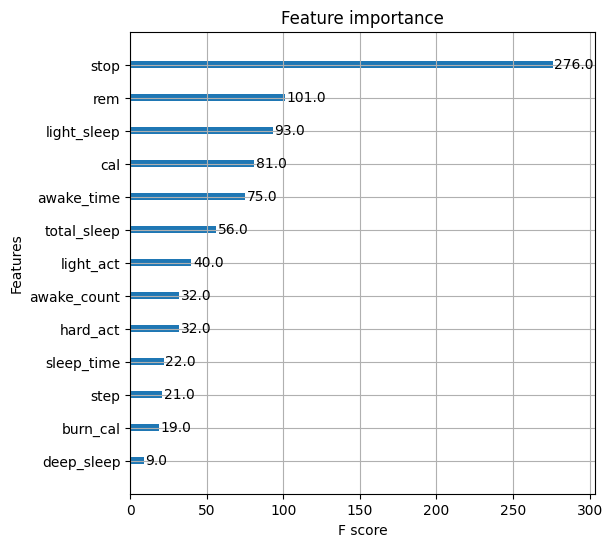

In [459]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
# %matplotlib inline

f, ax = plt.subplots(figsize=(6,6))
plot_importance(model,  ax=ax)